<a href="https://colab.research.google.com/github/charlesphu/kaggleComp/blob/main/kaggle_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import glob
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image
from torchvision.datasets import ImageFolder
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from google.colab import drive

from collections import Counter

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
drive.mount('/content/drive')
!pwd
%cd drive/MyDrive/cse164
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/cse164
/content/drive/MyDrive/cse164


In [4]:
# Globals
BATCH_SIZE = 64
NUM_CLASSES = 50
CONF_THRESHOLD = 0.85
EPOCHS = 50
IMAGE_SIZE = 224
MODEL_SAVE_DIR = 'saved_models'

torch.Size([16, 3, 128, 128])
torch.Size([16])
torch.Size([16, 128, 128])


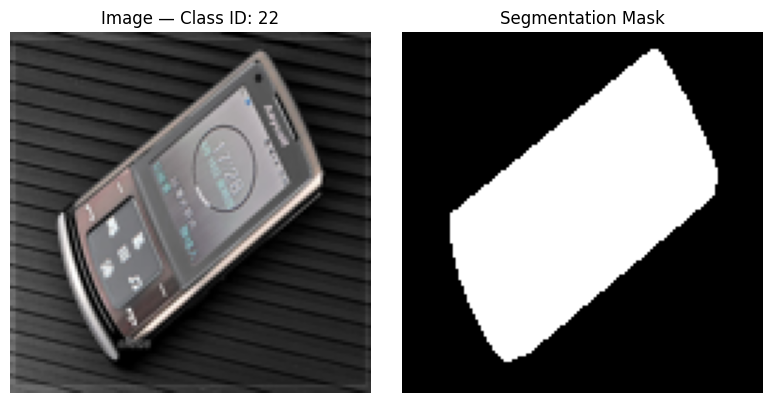

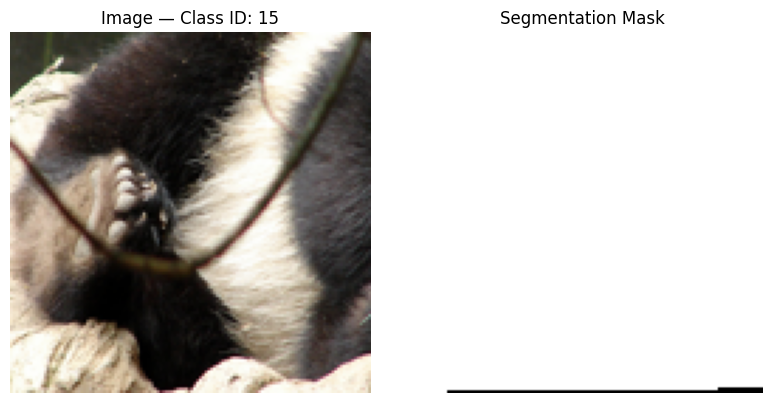

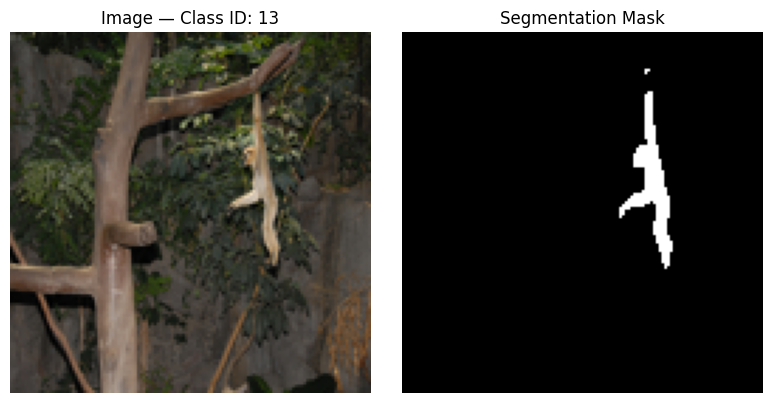

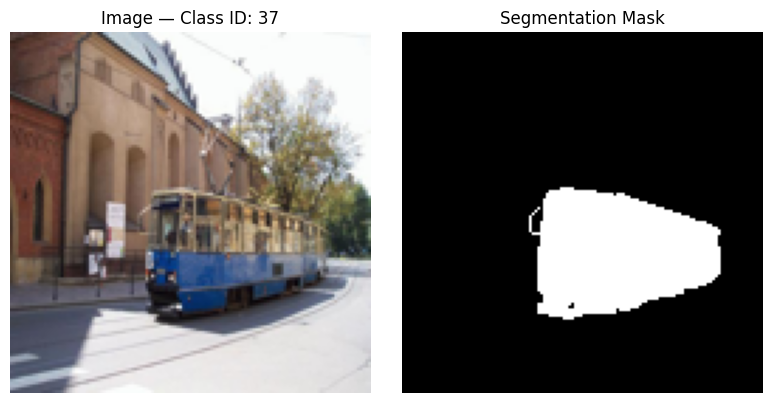

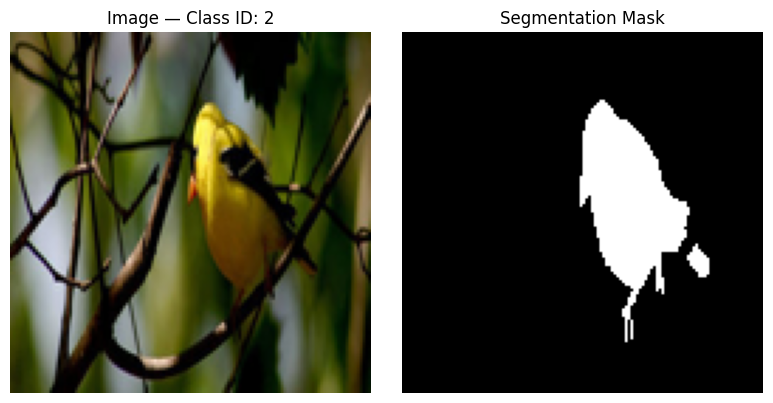

In [60]:
class ImageNetSubsetSegmentationDataset(Dataset):
    def __init__(self, json_path, image_size=(128, 128), mode='both', augmentation=None):
        self.image_dir = "train-semi"
        self.mask_dir = "train-semi-segmentation"
        self.mode = mode
        self.image_size = image_size
        self.augmentation = augmentation

        with open(json_path, "r") as f:
            self.samples = json.load(f)

        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        entry = self.samples[idx]
        image_rel = entry["image"]
        mask_rel = entry["mask"]
        class_id = entry["class_id"]

        image_path = os.path.join(self.image_dir, image_rel)
        if not os.path.exists(image_path):
            pattern = os.path.splitext(image_path)[0] + ".*"
            matches = glob.glob(pattern)
            if matches:
                image_path = matches[0]
            else:
                raise FileNotFoundError(f"Image not found: {image_rel}")

        mask_path = os.path.join(self.mask_dir, mask_rel)
        if not os.path.exists(mask_path):
            pattern = os.path.splitext(mask_path)[0] + ".*"
            matches = glob.glob(pattern)
            if matches:
                mask_path = matches[0]
            else:
                raise FileNotFoundError(f"Mask not found: {mask_rel}")

        # Load image and mask
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))[..., 0]  # Take R channel

        # Apply augmentation
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            # Apply default resizing and tensor conversion if no augmentation
            image = Image.fromarray(image).resize(self.image_size)
            mask = Image.fromarray(mask).resize(self.image_size, resample=Image.NEAREST)
            image = transforms.ToTensor()(image)
            mask = torch.from_numpy(np.array(mask)).long()

        if self.mode == "classification":
            return image, class_id
        elif self.mode == "segmentation":
            return image, mask
        else:
            return image, class_id, mask

augmentation = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    ToTensorV2()
])

dataset = ImageNetSubsetSegmentationDataset(
    json_path="train_semi_annotations_with_seg_ids.json",
    mode='both',
    augmentation=None
)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Inspect one batch
images, class_ids, masks = next(iter(dataloader))
print(images.shape)     # [16, 3, 128, 128]
print(class_ids.shape)  # [16]
print(masks.shape)      # [16, 128, 128]

def plot_segmentation(image, mask, class_id=None):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(to_pil_image(image.cpu()))
    axs[0].set_title(f"Image" + (f" — Class ID: {class_id}" if class_id is not None else ""))
    axs[0].axis("off")

    axs[1].imshow(mask.cpu(), cmap="gray")
    axs[1].set_title("Segmentation Mask")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

for i in range(5):
    plot_segmentation(images[i], masks[i], class_ids[i])

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class SEBlock(nn.Module):
#     """Squeeze-and-Excitation (SE) Block for channel-wise attention"""
#     def __init__(self, channels, reduction=16):
#         super(SEBlock, self).__init__()
#         self.fc1 = nn.Linear(channels, channels // reduction)
#         self.fc2 = nn.Linear(channels // reduction, channels)

#     def forward(self, x):
#         b, c, _, _ = x.size()
#         y = F.adaptive_avg_pool2d(x, 1).view(b, c)
#         y = F.relu(self.fc1(y))
#         y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
#         return x * y

# def conv_block(in_c, out_c, dropout=0.0):
#     layers = [
#         nn.Conv2d(in_c, out_c, 3, padding=1),
#         nn.BatchNorm2d(out_c),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(out_c, out_c, 3, padding=1),
#         nn.BatchNorm2d(out_c),
#         nn.ReLU(inplace=True),
#     ]
#     if dropout > 0:
#         layers.append(nn.Dropout(dropout))
#     layers.append(SEBlock(out_c))  # Add attention
#     return nn.Sequential(*layers)

# class UNet(nn.Module):
#     def __init__(self, in_channels=3, out_channels=NUM_CLASSES):
#         super(UNet, self).__init__()

#         self.enc1 = conv_block(in_channels, 64)
#         self.enc2 = conv_block(64, 128)
#         self.enc3 = conv_block(128, 256)
#         self.enc4 = conv_block(256, 512)

#         self.pool = nn.MaxPool2d(2)

#         self.bottleneck = conv_block(512, 1024)

#         self.up3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
#         self.dec3 = conv_block(1024, 512, dropout=0.3)

#         self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.dec2 = conv_block(512, 256, dropout=0.2)

#         self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.dec1 = conv_block(256, 128, dropout=0.1)

#         self.up0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.dec0 = conv_block(128, 64)

#         self.final = nn.Conv2d(64, out_channels, kernel_size=1)

#     def forward(self, x):
#         e1 = self.enc1(x)
#         e2 = self.enc2(self.pool(e1))
#         e3 = self.enc3(self.pool(e2))
#         e4 = self.enc4(self.pool(e3))

#         b = self.bottleneck(self.pool(e4))

#         d3 = self.up3(b)
#         d3 = torch.cat([d3, e4], dim=1)
#         d3 = self.dec3(d3)

#         d2 = self.up2(d3)
#         d2 = torch.cat([d2, e3], dim=1)
#         d2 = self.dec2(d2)

#         d1 = self.up1(d2)
#         d1 = torch.cat([d1, e2], dim=1)
#         d1 = self.dec1(d1)

#         d0 = self.up0(d1)
#         d0 = torch.cat([d0, e1], dim=1)
#         d0 = self.dec0(d0)

#         out = self.final(d0)
#         return F.softmax(out, dim=1)  # Use Softmax for multi-class segmentation


# class SimpleUNet(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleUNet, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # [B, 16, 64, 64]
#             nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # [B, 32, 32, 32]
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(32, 16, 2, stride=2),  # [B, 16, 64, 64]
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, num_classes, 2, stride=2)  # [B, num_classes, 128, 128]
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x  # logits [B, num_classes, H, W]


In [61]:
# --- Attention Block ---
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

# --- Conv Block with Dropout + Attention ---
def conv_block(in_c, out_c, dropout=0.0):
    layers = [
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    ]
    if dropout > 0:
        layers.append(nn.Dropout(dropout))
    layers.append(SEBlock(out_c))
    return nn.Sequential(*layers)

# --- Full UNet Model ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=NUM_CLASSES):
        super(UNet, self).__init__()

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec3 = conv_block(1024, 512, dropout=0.3)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = conv_block(512, 256, dropout=0.2)

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = conv_block(256, 128, dropout=0.1)

        self.up0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec0 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e4], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)

        d0 = self.up0(d1)
        d0 = torch.cat([d0, e1], dim=1)
        d0 = self.dec0(d0)

        out = self.final(d0)
        return out
        return F.softmax(out, dim=1)


In [62]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)
        preds_flat = preds.view(preds.size(0), preds.size(1), -1)
        targets_flat = F.one_hot(targets, preds.size(1)).permute(0, 3, 1, 2).reshape_as(preds_flat)

        intersection = (preds_flat * targets_flat).sum(2)
        union = preds_flat.sum(2) + targets_flat.sum(2)

        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score.mean()

# Combined loss
def combined_loss(preds, targets):
    ce = nn.CrossEntropyLoss()(preds, targets)
    dice = DiceLoss()(preds, targets)
    return ce + dice


In [63]:
def dice_score(preds, targets, smooth=1.0):
    preds = torch.argmax(preds, dim=1)
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat == targets_flat).float().sum()
    total = preds_flat.numel() + targets_flat.numel()
    return (2.0 * intersection + smooth) / (total + smooth)

def iou_score(preds, targets, smooth=1.0):
    preds = torch.argmax(preds, dim=1)
    intersection = ((preds == targets) & (targets > 0)).float().sum()
    union = ((preds > 0) | (targets > 0)).float().sum()
    return (intersection + smooth) / (union + smooth)


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
model = UNet(in_channels=3, out_channels=233).to(device)
# model = SimpleUNet(232 + 1).to(device)
criterion = nn.CrossEntropyLoss()  # expects (B, C, H, W) logits and (B, H, W) target
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

using cuda


In [65]:
num_epochs = 5

def validate(model, val_loader, device):
    model.eval()
    total_dice, total_iou, total_loss = 0, 0, 0

    with torch.no_grad():
        for images, class_id, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            total_loss += combined_loss(outputs, masks).item()
            total_dice += dice_score(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

    n = len(val_loader)
    print(f"[Validation] Loss: {total_loss/n:.4f} | Dice: {total_dice/n:.4f} | IoU: {total_iou/n:.4f}")
    return total_loss/n, total_dice/n, total_iou/n

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, class_id, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    validate(model, dataloader, device)




Epoch [1/5], Train Loss: 6.4024
[Validation] Loss: 6.2805 | Dice: 0.2126 | IoU: 0.0042
Epoch [2/5], Train Loss: 6.2057
[Validation] Loss: 6.1714 | Dice: 0.3980 | IoU: 0.0076
Epoch [3/5], Train Loss: 6.1221
[Validation] Loss: 6.0916 | Dice: 0.4975 | IoU: 0.0115
Epoch [4/5], Train Loss: 6.0526
[Validation] Loss: 6.2161 | Dice: 0.5566 | IoU: 0.0184
Epoch [5/5], Train Loss: 5.9926
[Validation] Loss: 6.6132 | Dice: 0.5913 | IoU: 0.0137


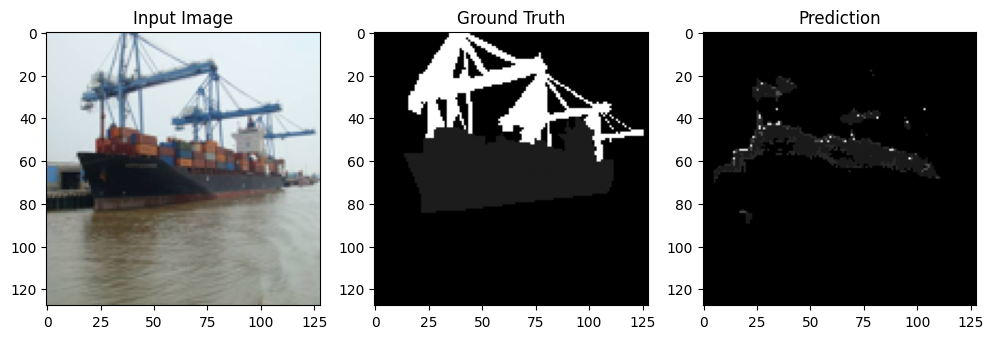

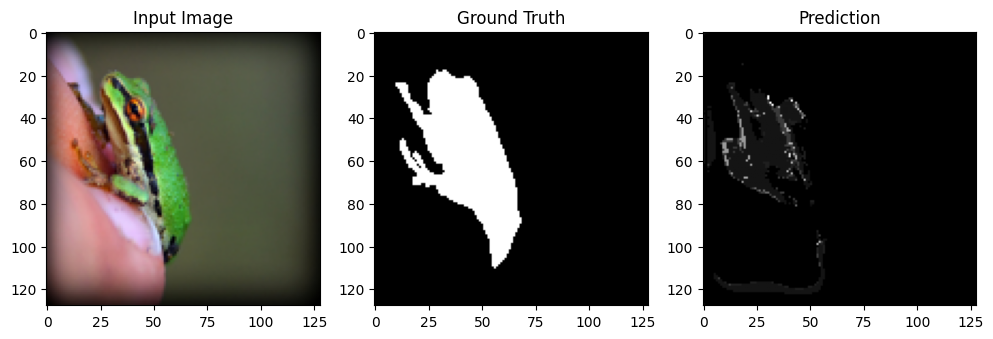

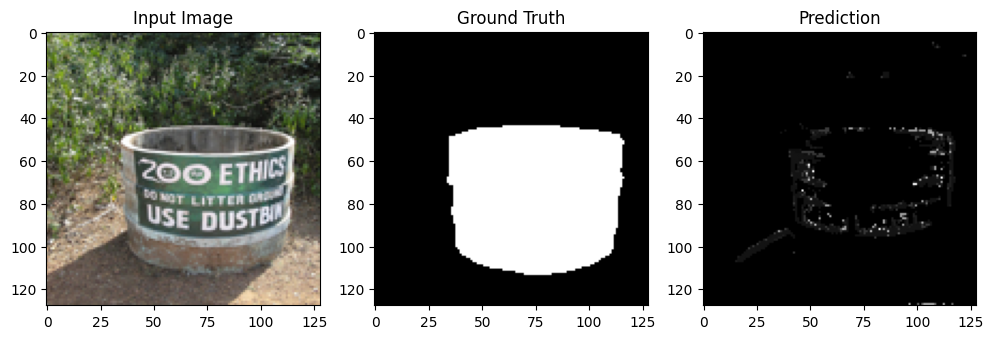

In [66]:
# Optionally visualize
def visualize_prediction(model, data_loader, device, num_samples=3):
    model.eval()
    images, class_id, masks = next(iter(data_loader))
    images = images.to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu())
        plt.title("Input Image")
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].cpu(), cmap="gray")
        plt.title("Ground Truth")
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].cpu(), cmap="gray")
        plt.title("Prediction")
        plt.show()

visualize_prediction(model, dataloader, device)

In [ ]:
# max_label = 0
# label_counts = Counter()

# for _, _, masks in dataloader:
#     max_label = max(max_label, masks.max().item())
#     label_counts.update(masks.view(-1).tolist())

# print(f"Max label found: {max_label}")
# print(f"Some label counts: {dict(list(label_counts.items())[:10])}")

In [ ]:
# from torch.utils.data import DataLoader

# # train_dataset = SegmentationDataset(img_dir, mask_dir, transform, target_transform)
# # dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# num_epochs = 100

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for images, class_id, masks in dataloader:
#         images, masks = images.to(device), masks.to(device)

#         outputs = model(images)  # [B, num_classes, H, W]
#         loss = criterion(outputs, masks)  # masks: [B, H, W]

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")


In [ ]:
# num_epochs = 15

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for images, class_ids, masks in dataloader:
#         images, masks = images.to(device), masks.to(device).long()

#         outputs = model(images)  # [B, num_classes, H, W]
#         loss = criterion(outputs, masks)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")


Unique predicted classes: tensor([  0,   6,  11,  14,  16,  17,  26,  29,  48,  50,  51,  90, 137])


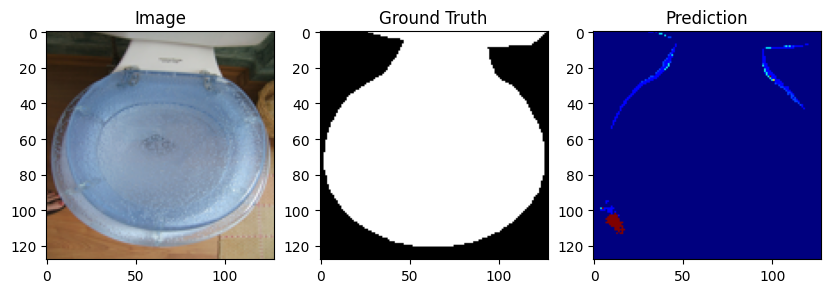

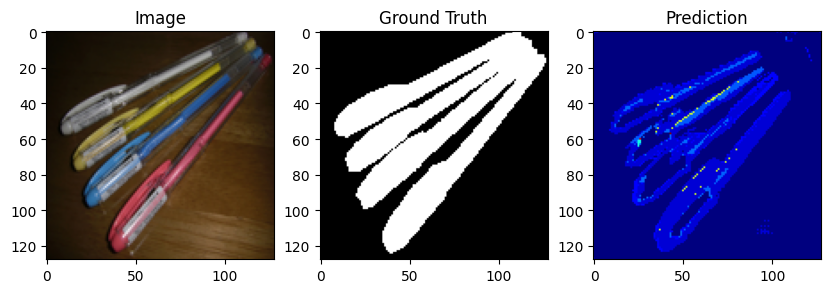

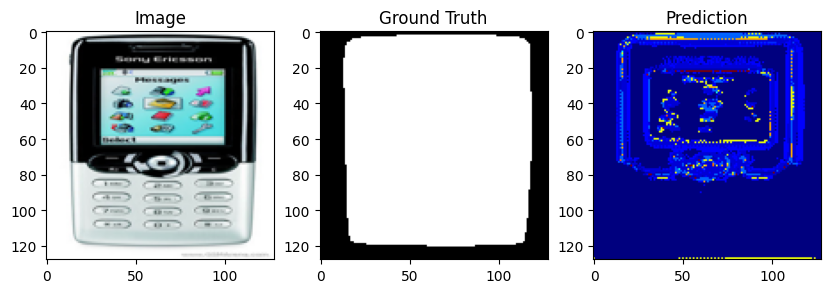

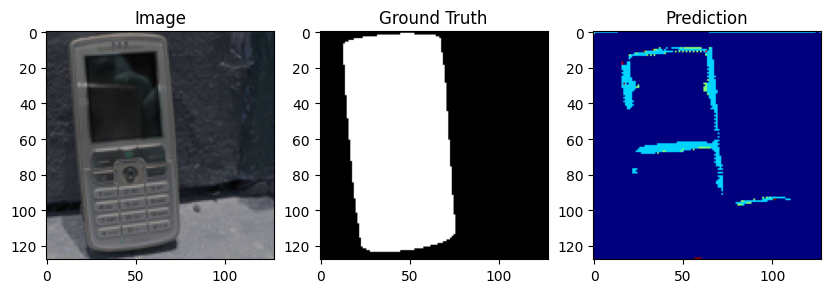

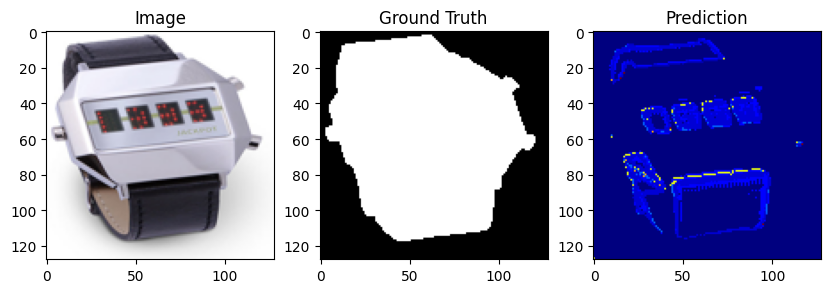

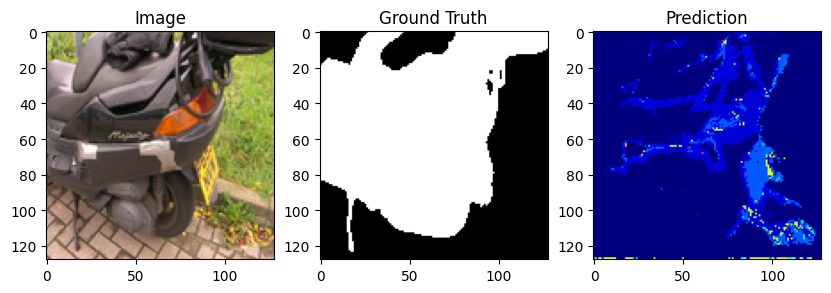

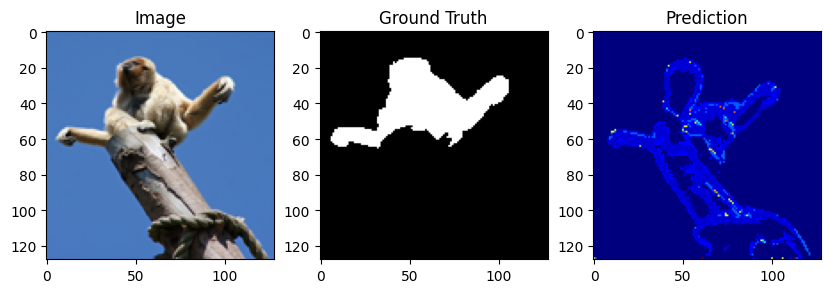

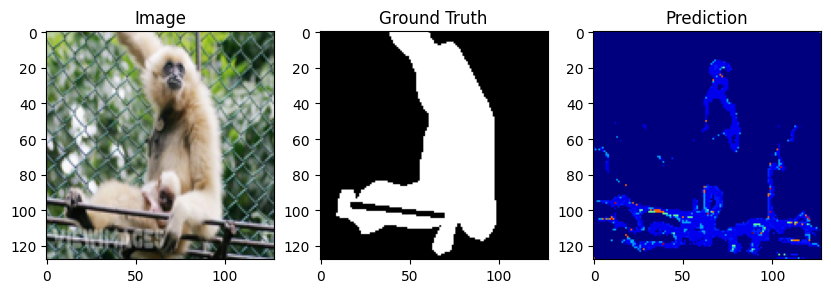

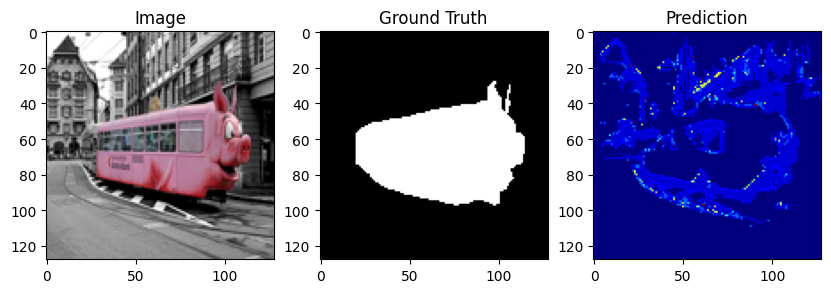

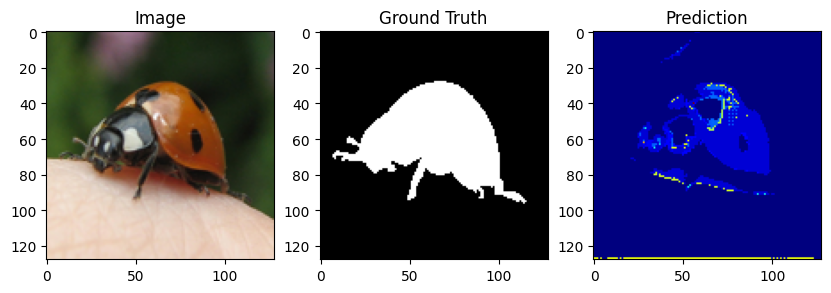

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
with torch.no_grad():
    images, class_ids, masks = next(iter(dataloader))
    images = images.to(device)
    preds = model(images)  # [B, num_classes, H, W]
    preds = torch.argmax(preds, dim=1).cpu()  # [B, H, W]
    print("Unique predicted classes:", torch.unique(preds[0]))

# Visualize the first one
for i in range(10):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(to_pil_image(images[i].cpu()))
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(masks[i].cpu(), cmap="gray")
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i], cmap="jet")
    plt.title("Prediction")
    plt.show()
